# Digit Classifier
#### by James Butcher
##### November 11, 2020

##### A Convolutional Neural Network that learns to classify handwritten digits from the MNIST data set

I am using this as a simple practice project for implementing a CNN and comparing the results of different architectures and hyperparameters.

I referred to the following youtube video for getting the basics up and running:
https://www.youtube.com/watch?v=OMDn66kM9Qc
I also borrowed from the lecture slides from Coursera's ASU:CSE 571 - Artificial Intelligence lecture video - week 5, Video: Identifying Digits with a CNN.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

### Network parameters:

In [2]:
in_channels = 1
conv1_channels = 8
conv2_channels = 16
fc_hidden = 64

num_classes = 10

### Network architecture (without dropout)

In [3]:
class CNN_mnist(nn.Module):
    def __init__(self):
        super(CNN_mnist, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv1_channels, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size=5, padding=2, stride=1)
        self.fc1 = nn.Linear(conv2_channels*7*7, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, num_classes)
        
    def forward(self, x):
        # Convolutional + max pooling layer 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        
        # Convolutional + max pooling layer 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        
        # Flatten
        x = x.view(-1, conv2_channels*7*7)
        
        # Fully connected layer 1
        x = F.relu(self.fc1(x))
        
        # Fully connected layer 2
        x = self.fc2(x)
    
        # Softmax output
        output = F.log_softmax(x, dim=1)
        
        return output

### Network architecture (with dropout)

In [4]:
dropout_probability = 0.5

In [5]:
class CNN_mnist_dropout(nn.Module):
    
    def __init__(self):
        super(CNN_mnist_dropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv1_channels, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size=5, padding=2, stride=1)
        self.dropout = nn.Dropout2d(p=dropout_probability)
        self.fc1 = nn.Linear(conv2_channels*7*7, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, num_classes)
        
    def forward(self, x):
        # Convolutional + max pooling layer 1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = self.dropout(x)
        
        # Convolutional + max pooling layer 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        x = self.dropout(x)
        
        # Flatten
        x = x.view(-1, conv2_channels*7*7)
        
        # Fully connected layer 1
        x = F.relu(self.fc1(x))
        
        # Fully connected layer 2
        x = self.fc2(x)
    
        # Softmax output
        output = F.log_softmax(x, dim=1)
        
        return output

### Define model, optimizer, and loss function

In [6]:
# Initialize models
model_without_dropout = CNN_mnist()
model_with_dropout = CNN_mnist_dropout()

In [7]:
# Define Optimizers
learning_rate = 0.001
optimizer_without_dropout = optim.SGD(model_without_dropout.parameters(), lr=learning_rate)
optimizer_with_dropout = optim.SGD(model_with_dropout.parameters(), lr=learning_rate)

In [8]:
# Define Loss Function
loss = nn.CrossEntropyLoss()

### Pre-process data

In [9]:
mnist_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transforms.ToTensor())
train, test = random_split(mnist_data, [50000, 10000])
train_loader = DataLoader(train, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

### Train model

In [10]:
def train_model(model, epochs, optimizer, loss, train_loader, test_loader):
    start_time = time.time()
    train_losses_over_epochs = []
    test_losses_over_epochs = []
    for epoch in range(epochs):
        train_losses = []
        for batch in train_loader:
            x, y = batch

            # Feedforward the input images
            output = model(x)

            # Compute the loss
            l = loss(output, y)
            train_losses.append(l.item())

            # Compute the gradients
            model.zero_grad()
            l.backward()

            # Update the weights
            optimizer.step()

        print("Epoch {:>2}  --  Train Loss: {:.4f}".format(epoch+1, torch.tensor(train_losses).mean()), end="  ")
        train_losses_over_epochs.append(torch.tensor(train_losses).mean())

        # Evaluate model
        test_losses = []
        for batch in test_loader:
            x, y = batch

            with torch.no_grad():
                output = model(x)

            l = loss(output, y)

            test_losses.append(l.item())
        print("Test Loss: {:.4f}".format(torch.tensor(test_losses).mean()))
        test_losses_over_epochs.append(torch.tensor(test_losses).mean())

    end_time = time.time()
    print("Total training and evaluation time:{:.2f} seconds".format(end_time - start_time))
    return train_losses_over_epochs, test_losses_over_epochs

### Calculate Accuracy

In [11]:
def calculate_accuracy(model, test):
    num_matches = 0
    evaluation_loader = DataLoader(test, batch_size=1)
    for sample in evaluation_loader:
        x, y = sample

        with torch.no_grad():
            output = np.argmax(model(x))
    
        if output == y:
            num_matches += 1
    
    accuracy = num_matches / len(test)
    print("Final accuracy: {:.2f} %".format(accuracy*100))

### Plot training losses

In [12]:
def plot_losses(train_losses_over_epochs, test_losses_over_epochs):
    x_values = np.arange(1, len(train_losses_over_epochs) + 1)
    train_values = np.array(train_losses_over_epochs)
    test_values = np.array(test_losses_over_epochs)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(x_values, train_values, 'r', label='Training Loss')
    plt.plot(x_values, test_values, 'b', label='Testing Loss')
    plt.legend()
    plt.show()

# Run the classifier

In [15]:
epochs = 30

### Without dropout:

In [16]:
train_losses_over_epochs, test_losses_over_epochs = train_model(model_without_dropout, 
                                                                epochs, optimizer_without_dropout, loss, 
                                                                train_loader, test_loader)

Epoch  1  --  Train Loss: 2.2954  Test Loss: 2.2886
Epoch  2  --  Train Loss: 2.2775  Test Loss: 2.2609
Epoch  3  --  Train Loss: 2.2127  Test Loss: 2.1206
Epoch  4  --  Train Loss: 1.6740  Test Loss: 0.9861
Epoch  5  --  Train Loss: 0.6585  Test Loss: 0.4881
Epoch  6  --  Train Loss: 0.4233  Test Loss: 0.3784
Epoch  7  --  Train Loss: 0.3484  Test Loss: 0.3281
Epoch  8  --  Train Loss: 0.3070  Test Loss: 0.2955
Epoch  9  --  Train Loss: 0.2780  Test Loss: 0.2714
Epoch 10  --  Train Loss: 0.2552  Test Loss: 0.2514
Epoch 11  --  Train Loss: 0.2359  Test Loss: 0.2343
Epoch 12  --  Train Loss: 0.2196  Test Loss: 0.2195
Epoch 13  --  Train Loss: 0.2054  Test Loss: 0.2065
Epoch 14  --  Train Loss: 0.1929  Test Loss: 0.1949
Epoch 15  --  Train Loss: 0.1819  Test Loss: 0.1845
Epoch 16  --  Train Loss: 0.1721  Test Loss: 0.1751
Epoch 17  --  Train Loss: 0.1632  Test Loss: 0.1666
Epoch 18  --  Train Loss: 0.1553  Test Loss: 0.1588
Epoch 19  --  Train Loss: 0.1481  Test Loss: 0.1519
Epoch 20  --

In [17]:
calculate_accuracy(model_without_dropout, test)

Final accuracy: 96.90 %


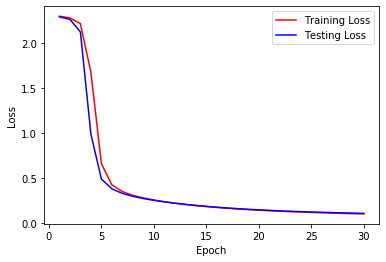

In [18]:
plot_losses(train_losses_over_epochs, test_losses_over_epochs)

### With dropout:

In [19]:
train_losses_over_epochs, test_losses_over_epochs = train_model(model_with_dropout, 
                                                                epochs, optimizer_with_dropout, loss, 
                                                                train_loader, test_loader)

Epoch  1  --  Train Loss: 2.3035  Test Loss: 2.3005
Epoch  2  --  Train Loss: 2.2951  Test Loss: 2.2901
Epoch  3  --  Train Loss: 2.2805  Test Loss: 2.2679
Epoch  4  --  Train Loss: 2.2323  Test Loss: 2.1680
Epoch  5  --  Train Loss: 1.9513  Test Loss: 1.6343
Epoch  6  --  Train Loss: 1.3335  Test Loss: 1.1306
Epoch  7  --  Train Loss: 1.0115  Test Loss: 0.9209
Epoch  8  --  Train Loss: 0.8697  Test Loss: 0.8141
Epoch  9  --  Train Loss: 0.7695  Test Loss: 0.7310
Epoch 10  --  Train Loss: 0.6951  Test Loss: 0.7027
Epoch 11  --  Train Loss: 0.6431  Test Loss: 0.6275
Epoch 12  --  Train Loss: 0.5957  Test Loss: 0.5825
Epoch 13  --  Train Loss: 0.5584  Test Loss: 0.5442
Epoch 14  --  Train Loss: 0.5289  Test Loss: 0.5430
Epoch 15  --  Train Loss: 0.5004  Test Loss: 0.5199
Epoch 16  --  Train Loss: 0.4828  Test Loss: 0.4830
Epoch 17  --  Train Loss: 0.4632  Test Loss: 0.4766
Epoch 18  --  Train Loss: 0.4481  Test Loss: 0.4435
Epoch 19  --  Train Loss: 0.4277  Test Loss: 0.4332
Epoch 20  --

In [20]:
calculate_accuracy(model_with_dropout, test)

Final accuracy: 92.06 %


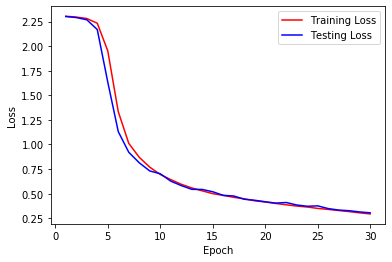

In [21]:
plot_losses(train_losses_over_epochs, test_losses_over_epochs)

### Notes - 11-12-2020:
- Using dropout caused the model to take longer to optimize.
- The final accuracy was 92.06% with dropout compared to 96.90% without dropout after training for 30 epochs.

- Question: Why is there no evidence of overfitting in both cases? Why doesn't the testing loss begin to increase at some point while the training loss plateaus? This is what dropout is supposed to mitigate.
    - Maybe the model has too few parameters? Maybe accuracy can be improved by increasing the number of layers and/or channels.
    - Maybe the dataset is sufficiently large. I could try using a smaller subset of the data: 

### Try to demonstrate overfitting by using a smaller chunk of the dataset

In [41]:
subset, _ = random_split(mnist_data, [6000, 54000])
small_train, small_test = random_split(subset, [5000, 1000])
small_train_loader = DataLoader(small_train, batch_size=10)
small_test_loader = DataLoader(small_test, batch_size=10)

### Without dropout

In [42]:
train_losses_over_epochs, test_losses_over_epochs = train_model(model_without_dropout, 
                                                                epochs, optimizer_without_dropout, loss, 
                                                                small_train_loader, small_test_loader)

Epoch  1  --  Train Loss: 0.1259  Test Loss: 0.1234
Epoch  2  --  Train Loss: 0.0974  Test Loss: 0.1148
Epoch  3  --  Train Loss: 0.0844  Test Loss: 0.1088
Epoch  4  --  Train Loss: 0.0764  Test Loss: 0.1058
Epoch  5  --  Train Loss: 0.0708  Test Loss: 0.1039
Epoch  6  --  Train Loss: 0.0663  Test Loss: 0.1028
Epoch  7  --  Train Loss: 0.0626  Test Loss: 0.1016
Epoch  8  --  Train Loss: 0.0595  Test Loss: 0.1009
Epoch  9  --  Train Loss: 0.0568  Test Loss: 0.1005
Epoch 10  --  Train Loss: 0.0544  Test Loss: 0.0999
Epoch 11  --  Train Loss: 0.0522  Test Loss: 0.0993
Epoch 12  --  Train Loss: 0.0502  Test Loss: 0.0987
Epoch 13  --  Train Loss: 0.0485  Test Loss: 0.0985
Epoch 14  --  Train Loss: 0.0468  Test Loss: 0.0983
Epoch 15  --  Train Loss: 0.0451  Test Loss: 0.0982
Epoch 16  --  Train Loss: 0.0436  Test Loss: 0.0980
Epoch 17  --  Train Loss: 0.0422  Test Loss: 0.0977
Epoch 18  --  Train Loss: 0.0409  Test Loss: 0.0974
Epoch 19  --  Train Loss: 0.0396  Test Loss: 0.0978
Epoch 20  --

In [43]:
calculate_accuracy(model_without_dropout, small_test)

Final accuracy: 96.00 %


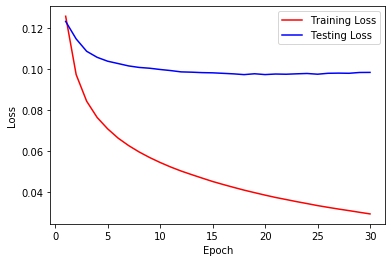

In [44]:
plot_losses(train_losses_over_epochs, test_losses_over_epochs)

### With dropout

In [45]:
train_losses_over_epochs, test_losses_over_epochs = train_model(model_with_dropout, 
                                                                epochs, optimizer_with_dropout, loss, 
                                                                small_train_loader, small_test_loader)

Epoch  1  --  Train Loss: 0.3138  Test Loss: 0.3278
Epoch  2  --  Train Loss: 0.3075  Test Loss: 0.3006
Epoch  3  --  Train Loss: 0.2903  Test Loss: 0.3096
Epoch  4  --  Train Loss: 0.2601  Test Loss: 0.3171
Epoch  5  --  Train Loss: 0.2645  Test Loss: 0.2732
Epoch  6  --  Train Loss: 0.2410  Test Loss: 0.2622
Epoch  7  --  Train Loss: 0.2402  Test Loss: 0.2571
Epoch  8  --  Train Loss: 0.2432  Test Loss: 0.2433
Epoch  9  --  Train Loss: 0.2252  Test Loss: 0.2485
Epoch 10  --  Train Loss: 0.2400  Test Loss: 0.2600
Epoch 11  --  Train Loss: 0.2251  Test Loss: 0.2458
Epoch 12  --  Train Loss: 0.2239  Test Loss: 0.2439
Epoch 13  --  Train Loss: 0.2196  Test Loss: 0.2541
Epoch 14  --  Train Loss: 0.2007  Test Loss: 0.2738
Epoch 15  --  Train Loss: 0.2006  Test Loss: 0.2875
Epoch 16  --  Train Loss: 0.2182  Test Loss: 0.2465
Epoch 17  --  Train Loss: 0.1963  Test Loss: 0.2223
Epoch 18  --  Train Loss: 0.1988  Test Loss: 0.2603
Epoch 19  --  Train Loss: 0.1990  Test Loss: 0.2402
Epoch 20  --

In [46]:
calculate_accuracy(model_with_dropout, small_test)

Final accuracy: 93.40 %


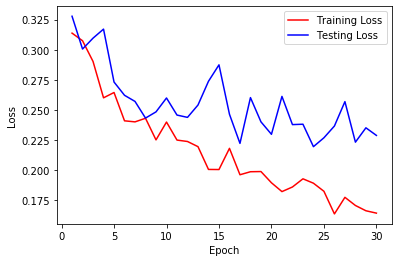

In [47]:
plot_losses(train_losses_over_epochs, test_losses_over_epochs)

- It didn't work. I have no idea why these two results look this way. I must come back to this after I learn and practice more.